In [9]:
import sys
sys.path.append('/Users/rustam/Documents/GitHub/python_exam_academy/Models')

In [10]:
# Для того, чтобы не выводились предупреждения и информация о логах

import logging
import os
import warnings


logging.getLogger('prophet').disabled = True
warnings.filterwarnings('ignore')

class suppress_stdout_stderr(object):

    def __init__(self):
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        self.save_fds = (os.dup(1), os.dup(2))

    def __enter__(self):
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        os.close(self.null_fds[0])
        os.close(self.null_fds[1])

In [11]:
# Подключаем библиотеки

import math 
import pandas as pd
import numpy as np
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from time import time

import holidays
import prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

import LinearRegression as linreg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [12]:
from google.oauth2 import service_account
project_id = 'kolesa-android-app'
credentials = '/Users/rustam/Kolesa/kolesa-android-app-715adc9bdf26.json'
credentials = service_account.Credentials.from_service_account_file(credentials)

In [13]:
q = """SELECT * FROM `kolesa-android-app.academy.time_series_dataset`
ORDER BY 1"""

In [14]:
data = pd.read_gbq(q, project_id=project_id, credentials=credentials, dialect='standard', progress_bar_type = 'tqdm')

Downloading: 100%|█████████████████████████████████████████████████████████████|


In [15]:
data

,event_date,y
0,2020-01-01,5721
1,2020-01-02,8274
2,2020-01-03,9344
3,2020-01-04,9864
4,2020-01-05,10435
...,...,...
1091,2022-12-27,17042
1092,2022-12-28,16195
1093,2022-12-29,14966
1094,2022-12-30,13070


In [16]:
data.columns = ['ds','y']
data.index = pd.to_datetime(data['ds'])
data['ds'] = pd.to_datetime(data['ds'])
data.head()

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435


In [17]:
cleaned_data = data.replace(10000000, (15767 + 15341) // 2)

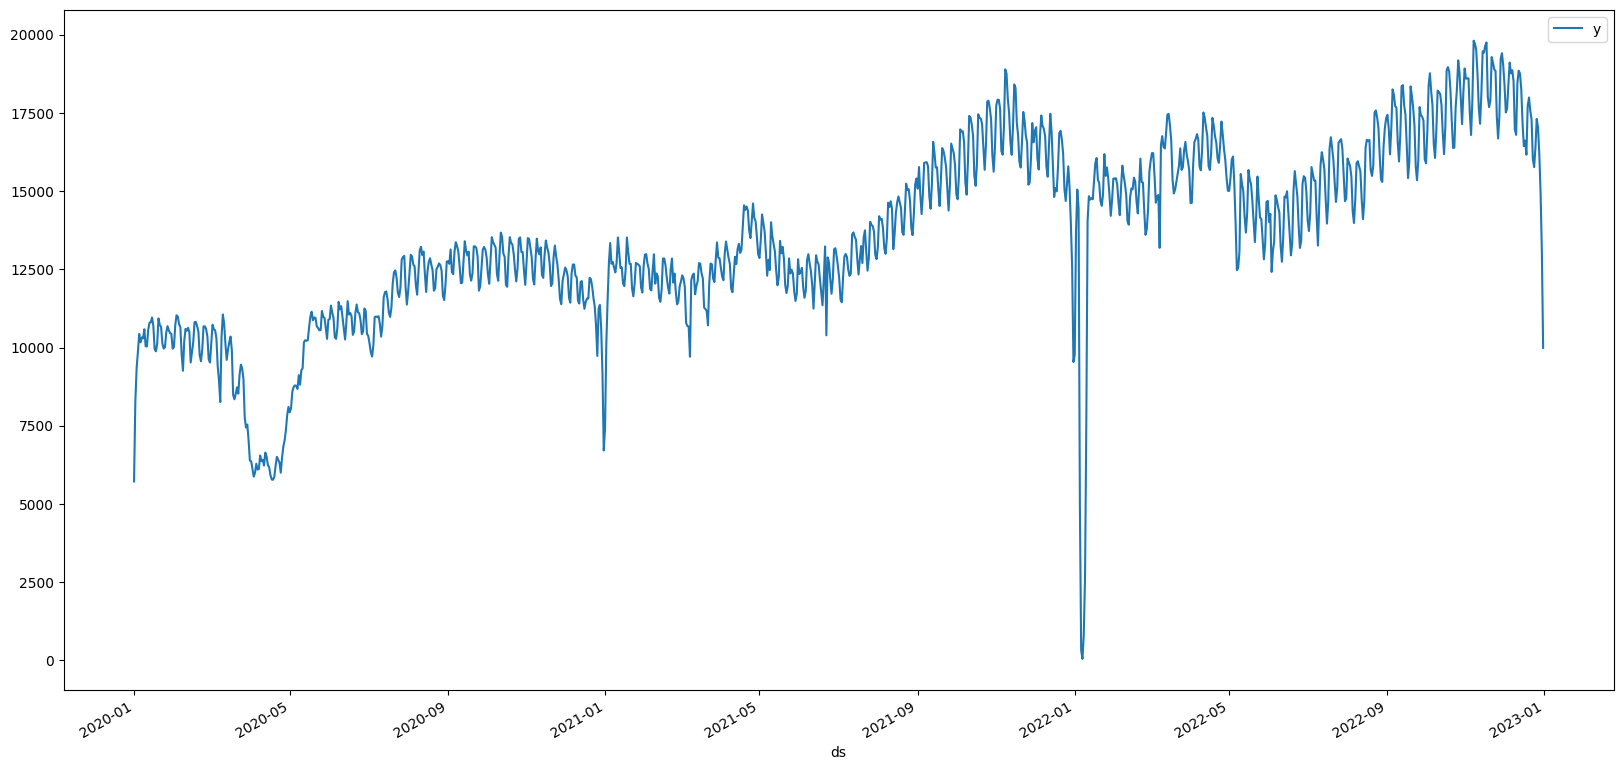

In [18]:
cleaned_data.plot(x="ds",y="y",kind="line", figsize=(20, 10));

In [19]:
date_start = '2022-01-05'
date_end = '2022-01-10'
cleaned_data.loc[(cleaned_data['ds'] >= date_start) & (cleaned_data['ds'] <= date_end), 'y'] = 14000
date_start = '2020-03-01'
date_end = '2020-06-01'
cleaned_data.loc[(cleaned_data['ds'] >= date_start) & (cleaned_data['ds'] <= date_end), 'y'] = 11000

<Axes: xlabel='ds'>

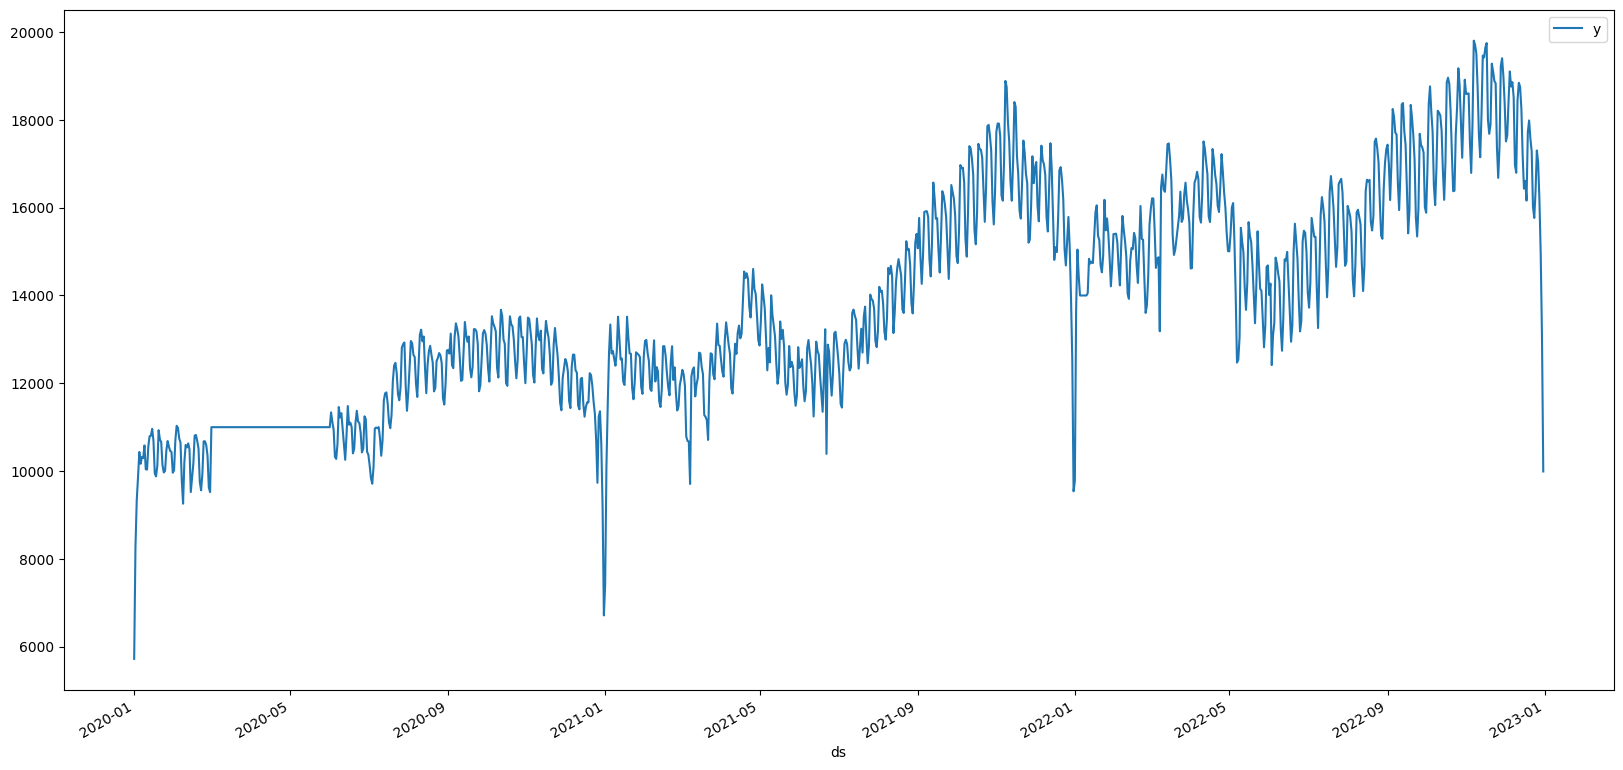

In [20]:
cleaned_data.plot(x="ds",y="y",kind="line", figsize=(20, 10))

In [21]:
cleaned_data

,ds,y
ds,,
2020-01-01,2020-01-01,5721
2020-01-02,2020-01-02,8274
2020-01-03,2020-01-03,9344
2020-01-04,2020-01-04,9864
2020-01-05,2020-01-05,10435
...,...,...
2022-12-27,2022-12-27,17042
2022-12-28,2022-12-28,16195
2022-12-29,2022-12-29,14966


In [22]:
# Разделение даты на год, месяц и день
cleaned_data['year'] = cleaned_data['ds'].dt.year
cleaned_data['month'] = cleaned_data['ds'].dt.month
cleaned_data['day'] = cleaned_data['ds'].dt.day

# Разделение данных на признаки (X) и целевую переменную (y)
#X = cleaned_data[['year', 'month', 'day']].values
X = np.array(cleaned_data[['year','month','day']], dtype=float)
y = np.array(cleaned_data['y'], dtype=float)

# Масштабирование данных (опционально, но может улучшить производительность модели)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Инициализация и обучение модели
model = linreg.LinearRegression(fit_intercept=True,
                             lr=0.01,
                             max_iter=10000,
                             sgd=True,
                             n_sample=32,
                             regularization=None,
                             alpha=0.0)
l = model.fit(X_scaled, y).get_losses()

# Прогнозирование на будущие даты
future_dates = pd.date_range(start='2020-01-06', end='2023-12-31')  
future_year = future_dates.year.values.reshape(-1, 1)
future_month = future_dates.month.values.reshape(-1, 1)
future_day = future_dates.day.values.reshape(-1, 1)
X_future = scaler.transform(np.hstack((future_year, future_month, future_day)))
y_pred = model.predict(X_future)

# Вывод результатов прогнозирования
future_predictions = pd.DataFrame({'ds': future_dates, 'predicted_y': y_pred})
print(future_predictions)

             ds   predicted_y
0    2020-01-06   9789.086052
1    2020-01-07   9791.304184
2    2020-01-08   9793.522316
3    2020-01-09   9795.740449
4    2020-01-10   9797.958581
...         ...           ...
1451 2023-12-27  20008.928994
1452 2023-12-28  20011.147126
1453 2023-12-29  20013.365258
1454 2023-12-30  20015.583390
1455 2023-12-31  20017.801523

[1456 rows x 2 columns]


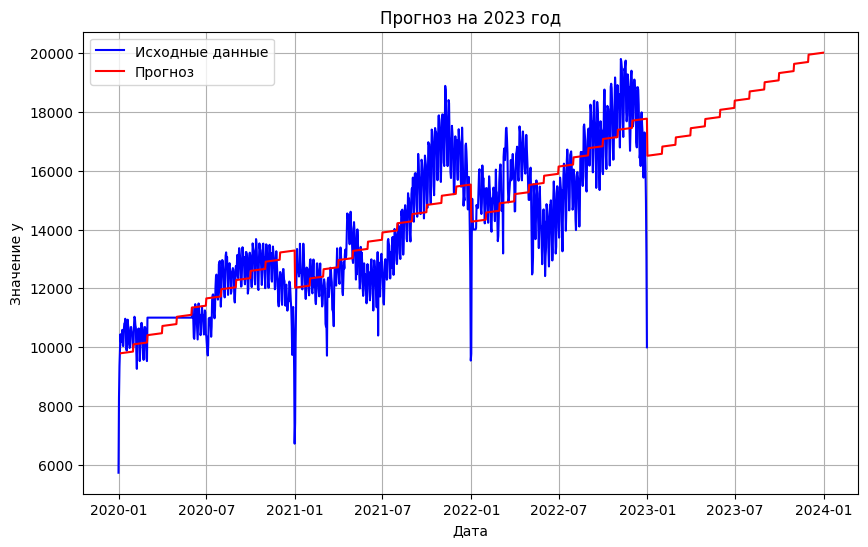

In [23]:
# Отображение результатов прогнозирования на графике
plt.figure(figsize=(10, 6))
plt.plot(cleaned_data['ds'], cleaned_data['y'], label='Исходные данные', color='blue')
plt.plot(future_predictions['ds'], future_predictions['predicted_y'], label='Прогноз', color='red')
plt.xlabel('Дата')
plt.ylabel('Значение y')
plt.title('Прогноз на 2023 год')
plt.legend()
plt.grid(True)
plt.show()

In [24]:
# Разделение даты на год, месяц и день
cleaned_data['year'] = cleaned_data['ds'].dt.year
cleaned_data['month'] = cleaned_data['ds'].dt.month
cleaned_data['day'] = cleaned_data['ds'].dt.day
cleaned_data['weekday'] = cleaned_data['ds'].dt.weekday

# Разделение данных на признаки (X) и целевую переменную (y)
#X = cleaned_data[['year', 'month', 'day']].values
X = np.array(cleaned_data[['year','month','day','weekday']], dtype=float)
y = np.array(cleaned_data['y'], dtype=float)

# Масштабирование данных (опционально, но может улучшить производительность модели)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Инициализация и обучение модели
model = linreg.LinearRegression(fit_intercept=True,
                             lr=0.01,
                             max_iter=10000,
                             sgd=True,
                             n_sample=32,
                             regularization=None,
                             alpha=0.0)
l = model.fit(X_scaled, y).get_losses()

# Прогнозирование на будущие даты
future_dates = pd.date_range(start='2020-01-06', end='2023-12-31')  
future_year = future_dates.year.values.reshape(-1, 1)
future_month = future_dates.month.values.reshape(-1, 1)
future_day = future_dates.day.values.reshape(-1, 1)
future_weekday = future_dates.weekday.values.reshape(-1, 1)
X_future = scaler.transform(np.hstack((future_year, future_month, future_day,future_weekday)))
y_pred = model.predict(X_future)

# Вывод результатов прогнозирования
future_predictions = pd.DataFrame({'ds': future_dates, 'predicted_y': y_pred})
print(future_predictions)

             ds   predicted_y
0    2020-01-06  10407.206391
1    2020-01-07  10197.258692
2    2020-01-08   9987.310994
3    2020-01-09   9777.363296
4    2020-01-10   9567.415598
...         ...           ...
1451 2023-12-27  20210.604160
1452 2023-12-28  20000.656462
1453 2023-12-29  19790.708763
1454 2023-12-30  19580.761065
1455 2023-12-31  19370.813367

[1456 rows x 2 columns]


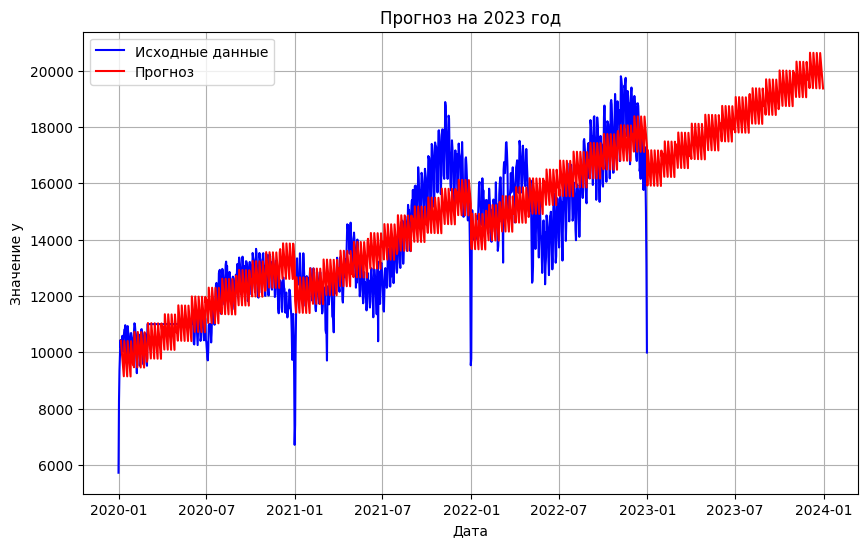

In [25]:
# Отображение результатов прогнозирования на графике
plt.figure(figsize=(10, 6))
plt.plot(cleaned_data['ds'], cleaned_data['y'], label='Исходные данные', color='blue')
plt.plot(future_predictions['ds'], future_predictions['predicted_y'], label='Прогноз', color='red')
plt.xlabel('Дата')
plt.ylabel('Значение y')
plt.title('Прогноз на 2023 год')
plt.legend()
plt.grid(True)
plt.show()

In [26]:
cleaned_data

,ds,y,year,month,day,weekday
ds,,,,,,
2020-01-01,2020-01-01,5721,2020,1,1,2
2020-01-02,2020-01-02,8274,2020,1,2,3
2020-01-03,2020-01-03,9344,2020,1,3,4
2020-01-04,2020-01-04,9864,2020,1,4,5
2020-01-05,2020-01-05,10435,2020,1,5,6
...,...,...,...,...,...,...
2022-12-27,2022-12-27,17042,2022,12,27,1
2022-12-28,2022-12-28,16195,2022,12,28,2
2022-12-29,2022-12-29,14966,2022,12,29,3
